### Math
- Resource is defined as $res$
$$0<=res<=1$$
- Logistic population growth:
$$\frac{dN}{dt} = {\color{red}r}N(1-\frac{N}{K})$$
where $\color{red}r$ is modified as "resource" times "birth rate at max resource"
$$\color{red}{r=res\times bA}$$
which means more resource more growth. Actually $\color{red}{r}$ is not ture birth rate because RHS also has factor $(1-\frac{N}{K})$ for logistic assumption.


- Population diffusion
$$\frac{\partial N}{\partial t} = {\color{red}D}(\frac{\partial^2 N}{\partial x^2}+\frac{\partial^2 N}{\partial y^2})+\frac{\partial {\color{red}D}\partial N}{\partial x^2}+\frac{\partial {\color{red}D}\partial N}{\partial y^2}$$
where $\color{red}D$ is modified as "1-resource" times "diffusion rate at 0 resource"
$$\color{red}{D=(1-res)\times dA}$$
which means more resource less travelling.


When considering both the math models above, we have 
$$\frac{\partial N}{\partial t} = {\color{red}r}N(1-\frac{N}{K}) + {\color{red}D}(\frac{\partial^2 N}{\partial x^2}+\frac{\partial^2 N}{\partial y^2})+\frac{\partial {\color{red}D}\partial N}{\partial x^2}+\frac{\partial {\color{red}D}\partial N}{\partial y^2}$$
This is solved by FTCS scheme.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

class resource_map:
    def __init__(self, xA, yA, d):
        self.d = d              # d = mesh width, length [km]
        self.x = int(xA/d)+1    # xA = area width [km]
        self.y = int(yA/d)+1    # yA = area length [km]
        self.rm = np.zeros((self.y, self.x), dtype="float")
    def random(self, ex, ave = 0.5, flu = 0.5, x0 = 0, y0 = 0, xl = None, yl = None):
        if xl is None: xl = self.x
        if yl is None: yl = self.y
        temp = np.zeros((yl+2*ex, xl+2*ex), dtype="float")
        for i in range(yl+2*ex):
            for j in range(xl+2*ex):
                temp[i][j] = random.uniform(ave-flu, ave+flu)
        for i in range(yl):
            for j in range(xl):
                self.rm[i+y0][j+x0] = np.average(temp[i:i+2*ex+1,j:j+2*ex+1])
    def disp(self, title = None):
        cmap = plt.cm.get_cmap("jet")
        cmap.set_over('grey')
        cmap.set_under('black')
        levels = np.arange(0, 1, 0.01)
        plt.cla()
        plt.clf()
        plt.xlim(0, self.x-1)
        plt.ylim(0, self.y-1)
        cl = plt.contourf(self.rm, levels, cmap=cmap)
        plt.colorbar(cl)
        if title: plt.title(title)
        plt.show()
#    def output_vtk(self):

class animal:
    def __init__(self, bA, dA, k):
        self.bA = bA         # bA = birth rate at max resource [Births / year / population]
        self.k = k           # k = maximum population in 1km*1km [population]
        self.dA = dA         # dA = diffusion rate at 0 resource [km^2 / year]

class population_map:
    def __init__(self, res, ani):
        self.res = res
        self.ani = ani
        self.pm = np.zeros((res.y, res.x), dtype="float")
    def disp(self, title = None):
        cmap = plt.cm.get_cmap("jet")
        cmap.set_over('grey')
        cmap.set_under('black')
        levels = np.arange(0, np.max(self.pm)+1, 1)
        plt.cla()
        plt.clf()
        plt.xlim(0, self.res.x-1)
        plt.ylim(0, self.res.y-1)
        cl = plt.contourf(self.pm, levels, cmap=cmap)
        plt.colorbar(cl)
        if title: plt.title(title)
        plt.show()
    def run(self, t, dt):
        n = int(t / dt)
        for i in range(n):
            growth = self.res.rm * self.ani.bA * self.pm * (1 - self.pm/self.res.d**2/self.ani.k) * dt
            diffusion = (1 - self.res.rm) * self.ani.dA * (np.roll(self.pm,1,0)+np.roll(self.pm,-1,0)+np.roll(self.pm,1,1)+np.roll(self.pm,-1,1)-4*self.pm) / self.res.d**2 * dt
            diffusion += self.ani.dA * ((np.roll(1-self.res.rm,-1,0)-np.roll(1-self.res.rm,1,0))*(np.roll(self.pm,-1,0)-np.roll(self.pm,1,0)) + (np.roll(1-self.res.rm,-1,1)-np.roll(1-self.res.rm,1,1))*(np.roll(self.pm,-1,1)-np.roll(self.pm,1,1))) / 4 / self.res.d**2 * dt
            #diffusion += self.ani.dA * ((np.roll(self.res.rm-1,-1,0)-np.roll(self.res.rm-1,1,0))*(np.roll(self.pm,-1,0)-np.roll(self.pm,1,0)) + (np.roll(self.res.rm-1,-1,1)-np.roll(self.res.rm-1,1,1))*(np.roll(self.pm,-1,1)-np.roll(self.pm,1,1))) / 4 / self.res.d**2 * dt
            self.pm += growth + diffusion
            self.pm[:,0] = 0; self.pm[:,self.res.x-1] = 0; self.pm[0,:] = 0; self.pm[self.res.y-1,:] = 0
#     def run_output_vtk(self)

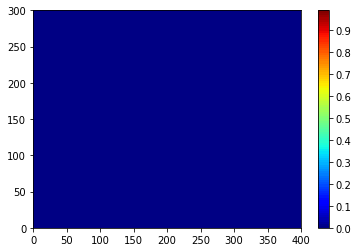

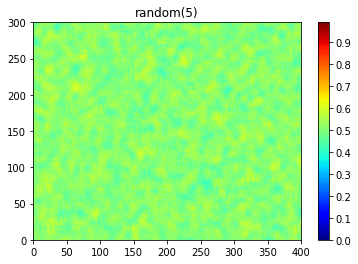

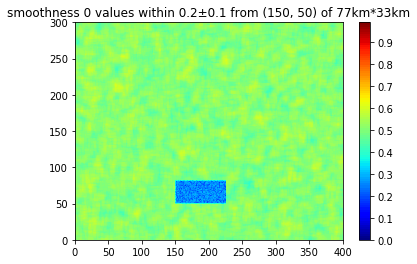

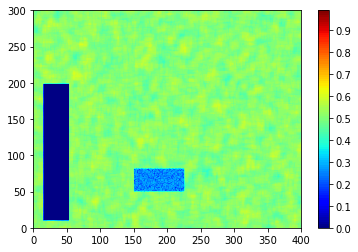

In [2]:
# resource map demonstration
m1 = resource_map(400, 300, 1)                 # generate m1 as an empty resource map of 400km*300km by 1km*1km mesh
m1.disp()                                      # display map m1
m1.random(5)                                   # give m1 random values; map is more smooth when argument is set to be larger 
m1.disp("random(5)")                           # display map function can pass figure title
m1.random(0, 0.2, 0.1, 150, 50, 77, 33)        # give m1 random values(advanced); arguments are (smoothness, average, fluctuation, origin x, origin y, width, length)
m1.disp("smoothness 0 values within 0.2±0.1 from (150, 50) of 77km*33km") 
m1.rm[10:200, 15:55] = 0                       # set values for m1 manually
m1.disp()

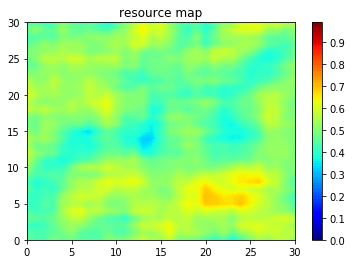

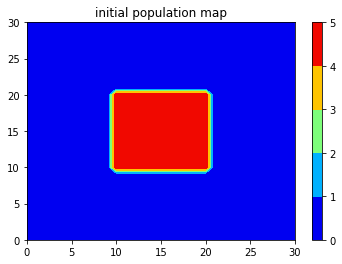

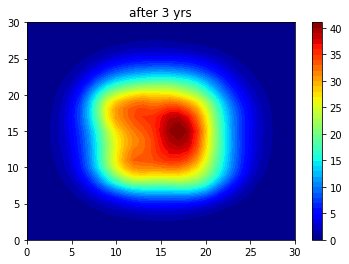

In [3]:
# simulation demonstration
res = resource_map(30, 30, 1)
res.random(2)
ani = animal(2, 3, 100)
p1 = population_map(res, ani)
p1.res.disp("resource map")
p1.pm[10:21, 10:21] = 5
p1.disp("initial population map")
p1.run(3, 0.01)
p1.disp("after 3 yrs")

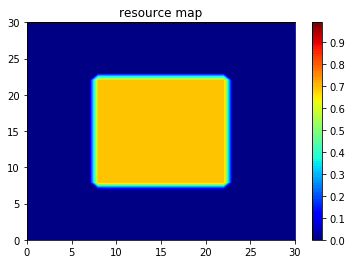

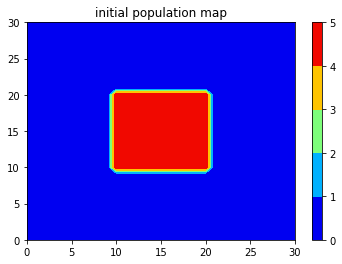

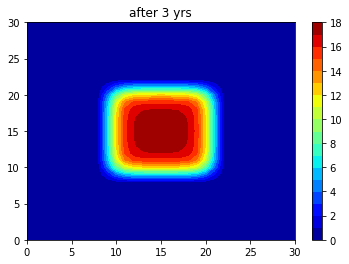

In [4]:
res = resource_map(30, 30, 1)
res.rm[8:23, 8:23] = 0.7
ani = animal(2, 3, 100)
p1 = population_map(res, ani)
p1.res.disp("resource map")
p1.pm[10:21, 10:21] = 5
p1.disp("initial population map")
p1.run(1, 0.01)
p1.disp("after 3 yrs")

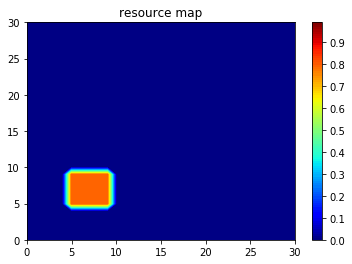

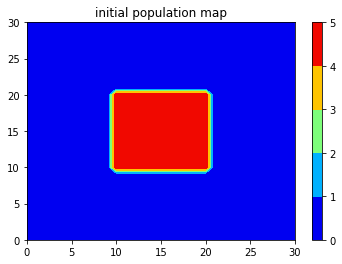

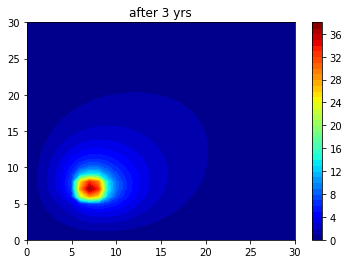

In [5]:
res = resource_map(30, 30, 1)
res.rm[5:10, 5:10] = 0.8
ani = animal(5, 15, 100)
p1 = population_map(res, ani)
p1.res.disp("resource map")
p1.pm[10:21, 10:21] = 5
p1.disp("initial population map")
p1.run(3, 0.01)
p1.disp("after 3 yrs")